In [1]:
from functools import partial

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from multiprocessing import Pool

from algorithms.C45 import C45
from algorithms.ID3 import ID3
from algorithms.RandomForest import RandomForest
from algorithms.SklearnModel import SklearnModel
from utils import load_gender_dataset, load_car_dataset
import warnings
from typing import Tuple, Dict, List, Callable, Any, Iterable
warnings.filterwarnings('ignore')

In [2]:
def main() -> None:
    df, discrete_columns = load_gender_dataset()

    X, Y = df.drop(columns=['target']), df['target']

    classifiers = [
        # ('ID3', ID3(max_depth=5, features_to_use=list(set(discrete_columns.keys())))),
        # ('C45',
        #  C45(max_depth=5, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0, random_state=42)),
        ('DecisionTree', SklearnModel(DecisionTreeClassifier, max_depth=50, discrete_feature_order=discrete_columns)),
        ('RandomForestC45', RandomForest(
            n_estimators=20,
            tree_constructor=partial(SklearnModel, DecisionTreeClassifier, max_depth=50, discrete_feature_order=discrete_columns),
            # tree_constructor=partial(C45, max_depth=5, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0),
            max_features=6, bootstrap_fraction=0.8)),
        ('RandomForestC45_noweighting', RandomForest(
            n_estimators=20,
            tree_constructor=partial(SklearnModel, DecisionTreeClassifier, max_depth=50,
                                     discrete_feature_order=discrete_columns),
            # tree_constructor=partial(C45, max_depth=5, discrete_features=list(discrete_columns.keys()), validation_ratio=0.0),
            max_features=6, bootstrap_fraction=0.8, sampling_temperature=0)),
    ]

    accuracies = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    for name, clf in classifiers:
        accuracies.append([])
        for train_idx, val_idx in skf.split(X, Y):
            clf.fit(X.iloc[train_idx], Y.iloc[train_idx])
            Y_pred = clf.predict(X.iloc[val_idx])
            accuracy = accuracy_score(Y.iloc[val_idx], Y_pred)
            accuracies[-1].append(accuracy)
        print(f"{name} Accuracy: {np.mean(accuracies[-1]):.4f} +/- {np.std(accuracies[-1]):.4f}")

    names, acc_values = zip(*classifiers)
    plt.figure(figsize=(15, 5))
    sns.barplot(data=pd.DataFrame([(name, acc) for name, accs in zip(names, accuracies) for acc in accs]), x=0, y=1)
    plt.ylabel('Accuracy')
    plt.title('Comparison of Classifier Accuracies on the Gender Classification Dataset')

DecisionTree Accuracy: 0.9630 +/- 0.0073
RandomForestC45 Accuracy: 0.9698 +/- 0.0036
RandomForestC45_noweighting Accuracy: 0.9726 +/- 0.0050


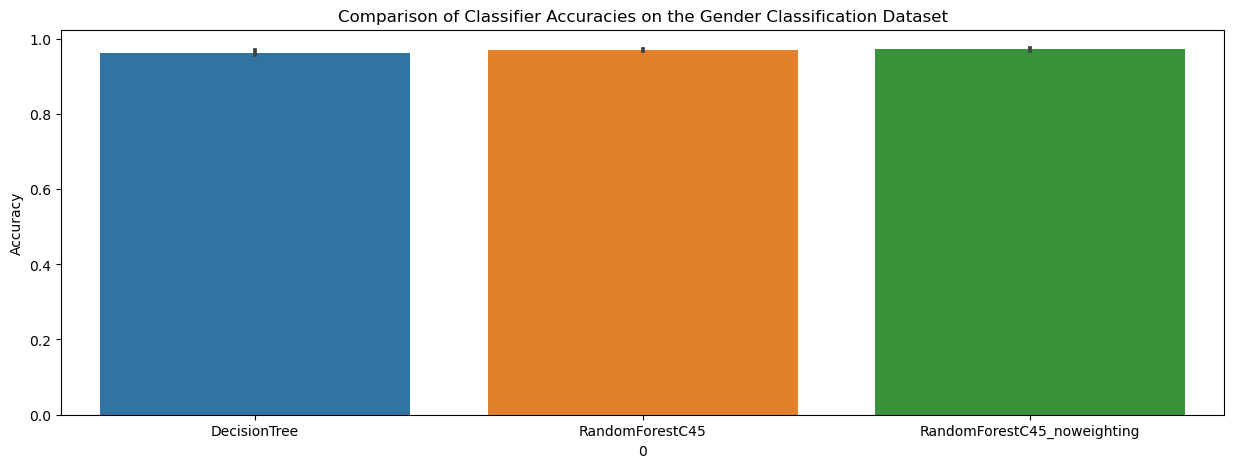

In [3]:
main()

## Dodatkowe funkcje

### Load Dataset

In [4]:
def load_dataset(dataset_name: str):
    if dataset_name == 'gender':
        df, cols = load_gender_dataset()
        target_column = 'target'
    elif dataset_name == 'car':
        df, cols = load_car_dataset()
        target_column = 'target'
    else:
        raise ValueError("Invalid dataset name. Choose either 'gender' or 'car'.")
    return df, cols

### Data Split

In [5]:
def data_split(df, val_fraction, stratification_target='target', seed=0):
    """
    Returns a tuple (training dataframe, validation/test dataframe)
    """
    random_state = np.random.RandomState(seed)

    train_dfs = []
    val_dfs = []
    for _, df_group in df.groupby(stratification_target):
        indices = np.arange(len(df_group))
        random_state.shuffle(indices)
        val_indices = indices[:round(val_fraction * len(indices))]
        train_indices = indices[round(val_fraction * len(indices)):]

        train_dfs.append(df_group.iloc[train_indices])
        val_dfs.append(df_group.iloc[val_indices])

    return pd.concat(train_dfs), pd.concat(val_dfs)

### Cross Validation

In [6]:
def cross_validation_split(df, split_count, stratification_target="target", seed=0):
    """
    Cross validation function
    Returns a list of tuples (training dataframe, validation/test dataframe)
    """
    random_state = np.random.RandomState(seed)

    train_dfs: List[List[pd.DataFrame]] = []  # train_dfs[stratification_target_index][split_number]
    val_dfs = []
    for _, df_group in df.groupby(stratification_target):
        indices = np.arange(len(df_group))
        random_state.shuffle(indices)

        train_dfs.append([])
        val_dfs.append([])
        for split_number in range(split_count):
            # len(indices) / split_count -- approximated elements in one chunk
            val_start = round(split_number * len(indices) / split_count)
            val_end = round((split_number + 1) * len(indices) / split_count)
            val_indices = indices[val_start:val_end]
            train_indices = np.concatenate((indices[:val_start], indices[val_end:]))

            train_dfs[-1].append(df_group.iloc[train_indices])
            val_dfs[-1].append(df_group.iloc[val_indices])

    return [
        (pd.concat([dfs[i] for dfs in train_dfs]), pd.concat([dfs[i] for dfs in val_dfs])) for i in range(split_count)
    ]

### Calculate Macro Accuracy 

In [7]:
def macro_accuracy(ground_truth, y_pred):
    cm = confusion_matrix(ground_truth, y_pred)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    macro_accuracy = np.mean(class_accuracies)
    
    return macro_accuracy

### Show Report

In [8]:
def show_report(data: Dict[str, np.ndarray], dfname: str, name=""):
    """
    data[split_name] -> (ground_truth, predictions)
    where ground_truth and predictions have shape either (num_reps x num_samples) or (num_samples)
    Plots confusion matrix and bar plot(contains metrics and values of them) 
    """
    # map ground truths and predictions to 2d np.array if they are 1d.
    data = {k: tuple(map(lambda v: (v if len(v.shape) == 2 else v.reshape(1, -1)), vs)) for k, vs in data.items()}
    
    plt.figure(figsize=(20, 5 * len(data)))
    plt.suptitle(name)
    
    for i, (split, (ground_truth, preds)) in enumerate(data.items()):
        ax = plt.subplot(len(data), 2, 1 + 2 * i)
        plt.title(split)
        ConfusionMatrixDisplay.from_predictions(ground_truth.reshape(-1), preds.reshape(-1), normalize="all", ax=ax)
    
    plt.subplot(1, 2, 2)
    if dfname == "gender":
        metrics = [
        (accuracy_score, "accuracy"),
        (lambda *args: macro_accuracy(*args), "macro_accuracy"),
        # (lambda *args: precision_score(*args, pos_label=["Female", "Male"]), "precision"),
        # (lambda *args: recall_score(*args, pos_label=["Female", "Male"]), "recall"),
        # (lambda *args: f1_score(*args, pos_label=["Female", "Male"]), "f1"),
    ]
    if dfname == "car":
        metrics = [
            (accuracy_score, "accuracy"),
            (lambda *args: macro_accuracy(*args), "macro_accuracy"),
        ]

    df = pd.DataFrame.from_dict(
        {
            "value": [
                metric(gt[i], preds[i])
                for metric, _ in metrics
                for split, (gt, preds) in data.items()
                for i, _ in enumerate(gt)
            ],
            "split": [split for _, _ in metrics for split, (gt, _) in data.items() for _ in gt],
            "metric": [metric_name for _, metric_name in metrics for _, (gt, _) in data.items() for _ in gt],
        }
    )
    sns.barplot(df, x="metric", y="value", hue="split", errorbar='sd')

    plt.show()

## Szukanie najlepszych hiperparametrów

In [9]:
def evaluate_model(X, Y, model_constructor, model_args, n_splits=5, verbose=True):
    """
    Evaluates the model using cross-validation and calculates accuracy.

    Parameters
    ----------
    X : DataFrame
        Features data.
    Y : Series
        Target data.
    model_constructor : callable
        Constructor for the model.
    model_args : dict
        Arguments for the model constructor.
    n_splits : int, optional
        The number of folds in the cross-validation, by default 5.
    verbose : bool, optional
        Whether to display extra output or not, by default True.

    Returns
    -------
    float
        Accuracy of the model.
    """
    preds = []
    gt = []
    
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=model_args['random_seed'])
    for i, (train_indices, val_indices) in enumerate(skf.split(X, Y)):
        model = model_constructor(**model_args)
        model.fit(X.iloc[train_indices], Y.iloc[train_indices])
        preds.append(model.predict(X.iloc[val_indices]))
        gt.append(Y.iloc[val_indices])

    preds = np.concatenate(preds)
    gt = np.concatenate(gt)
    if verbose:
        ConfusionMatrixDisplay.from_predictions(gt, preds, normalize="all")
    return (preds == gt).mean()

In [10]:
def plot_factor_dependency(X, Y, model_constructor, name, values, default_args, reps=5, xlog=False, pool=__builtins__, show=True):
    """
    Plots the dependency of the model's accuracy on a specific factor.

    Parameters
    ----------
    X : DataFrame
        Features data.
    Y : Series
        Target data.
    model_constructor : callable
        Constructor for the model.
    name : str
        The name of the factor to vary.
    values : list
        The values of the factor to try.
    default_args : dict
        Default arguments to pass to the model constructor.
    reps : int, optional
        Number of times to repeat the evaluation for each factor value, by default 5.
    xlog : bool, optional
        Whether to use a logarithmic scale for the x-axis, by default False.
    pool : Pool, optional
        An optional multiprocessing pool to parallelize the evaluation, by default Python's built-in functions.
    show : bool, optional
        Whether to display the plot immediately or not, by default True.
    """
    res = {name: [], 'accuracy': []}
    for arg in values:
        args = default_args.copy()
        args[name] = arg
        
        for accuracy in pool.map(partial(evaluate_model, X, Y, model_constructor, verbose=False), [args | {'random_seed': i} for i in range(reps)]):
            if isinstance(arg, float):
                res[name].append(arg)
            else:
                res[name].append(str(arg))
            res['accuracy'].append(accuracy)

    
    df = pd.DataFrame.from_dict(res) 
    sns.lineplot(data=df, x=name, y='accuracy', errorbar='sd')
    sns.scatterplot(data=df, x=name, y='accuracy', alpha=0.05)
    if xlog:
        plt.xscale('log')
    
    #Rysowanie poziomej najlepszej linnii
    aggregated_df = df.groupby(name).mean().reset_index()
    row = aggregated_df[aggregated_df.accuracy == aggregated_df.accuracy.max()].iloc[0]
    plt.axvline(row[name], linestyle='dashed', color='r')
    plt.title(f'{name}\nfound best {name}={row[name]} with average accuracy {row["accuracy"] * 100:.2f}%')
    if show:
        plt.show()

In [11]:
def id3_constructor(random_seed, **kwargs): 
    return ID3(features_to_use=list(columns.keys()), **kwargs)

def c45_constructor(**kwargs):
    return C45(discrete_features=list(columns.keys()), **kwargs)

def sklearn_constructor(random_seed, **kwargs):
    return SklearnModel(model_class=DecisionTreeClassifier, discrete_feature_order=columns, **kwargs)

def tree_constructor(kind, **kwargs):
    if kind == 'id3':
        return id3_constructor(**kwargs)
    elif kind == 'c45':
        return c45_constructor(**kwargs)
    elif kind == 'sklearn':
        return sklearn_constructor(**kwargs)
    else:
        assert 0
        
def rf_constructor(tree_kwargs, random_seed, **kwargs):
    return RandomForest(**kwargs, tree_constructor=lambda: tree_constructor(**tree_kwargs, random_seed=random_seed))

W powyższym kodzie, zaimplementowałam następujące funkcje:

1. `load_dataset('gender')` - Ta funkcja ładuje zbiór danych o płci, zwracając ramkę danych oraz słownik kolumn.

2. `id3_constructor(random_seed, **kwargs)` - Jest to konstruktor dla algorytmu drzewa decyzyjnego ID3. Pozwala on na przekazanie różnych argumentów do algorytmu (dzięki wykorzystaniu `**kwargs`) oraz na ustawienie konkretnego ziarna losowości (`random_seed`), które jest używane do kontrolowania losowości algorytmu.

3. `c45_constructor(**kwargs)` - Podobnie jak wyżej, jest to konstruktor dla algorytmu C4.5. Również pozwala na przekazanie różnych argumentów do algorytmu za pomocą `**kwargs`.

4. `tree_constructor(kind, **kwargs)` - Ta funkcja to wyższy poziom abstrakcji, który pozwala na wybór między konstruktorem ID3 a C4.5, w zależności od przekazanego argumentu `kind`.

5. `rf_constructor(tree_kwargs, random_seed, **kwargs)` - Jest to konstruktor dla algorytmu Random Forest. Pozwala na przekazanie argumentów do konstruktora drzewa (`tree_kwargs`), ustawienie ziarna losowości (`random_seed`) oraz na przekazanie dodatkowych argumentów do algorytmu Random Forest za pomocą `**kwargs`. Co ciekawe, tworzy on funkcję `lambda`, która zwraca konstruktor drzewa, pozwalając na dynamiczne tworzenie drzew w algorytmie Random Forest.

W ten sposób, mogłam zaimplementować konstruktory dla różnych algorytmów, umożliwiając łatwe tworzenie i konfigurację modeli.

## Car DataSet

### Maximum Depth

In [18]:
df, columns = load_dataset('car')
X, Y = df.drop(columns='target'), df['target']

In [19]:
X, Y, columns

(     buying  maint  doors persons lug_boot safety
 0     vhigh  vhigh      2       2    small    low
 1     vhigh  vhigh      2       2    small    med
 2     vhigh  vhigh      2       2    small   high
 3     vhigh  vhigh      2       2      med    low
 4     vhigh  vhigh      2       2      med    med
 ...     ...    ...    ...     ...      ...    ...
 1723    low    low  5more    more      med    med
 1724    low    low  5more    more      med   high
 1725    low    low  5more    more      big    low
 1726    low    low  5more    more      big    med
 1727    low    low  5more    more      big   high
 
 [1728 rows x 6 columns],
 0       unacc
 1       unacc
 2       unacc
 3       unacc
 4       unacc
         ...  
 1723     good
 1724    vgood
 1725    unacc
 1726     good
 1727    vgood
 Name: target, Length: 1728, dtype: object,
 {'buying': ['low', 'med', 'high', 'vhigh'],
  'maint': ['low', 'med', 'high', 'vhigh'],
  'doors': ['2', '3', '4', '5more'],
  'persons': ['2', '4', '

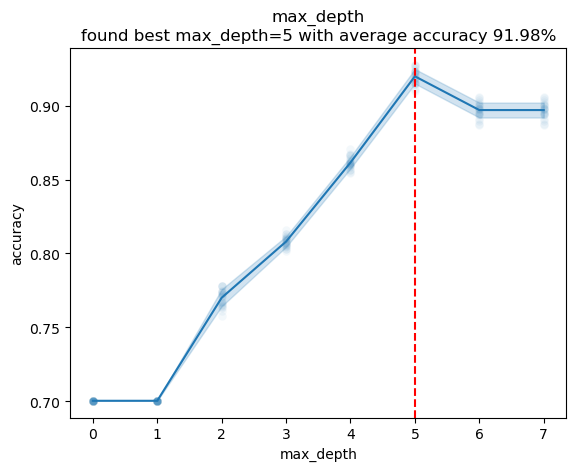

In [20]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, id3_constructor, 'max_depth', range(8), {}, reps=24, pool=pool)

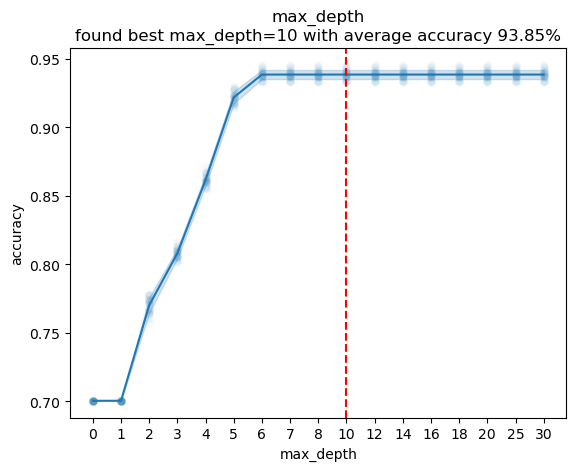

In [21]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'max_depth', [0 , 1, 2, 3, 4, 5, 6, 7,
                                                        8, 10, 12, 14, 16, 18, 20, 25, 30], {'validation_ratio': 0, 'criterion': 'inf_gain'}, reps=24, pool=pool)

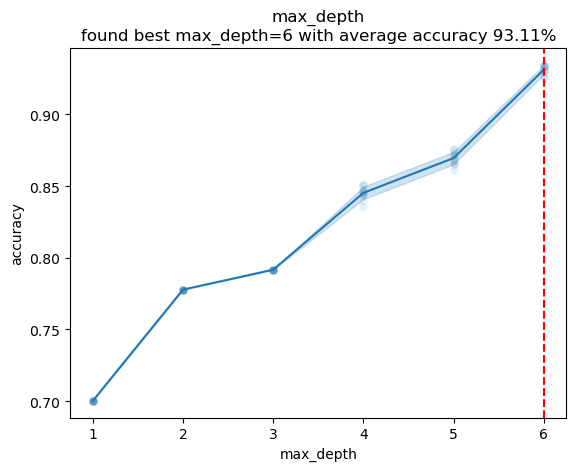

In [22]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, sklearn_constructor, 'max_depth', range(1, 7), {}, reps=24, pool=pool)

### Validation Ratio

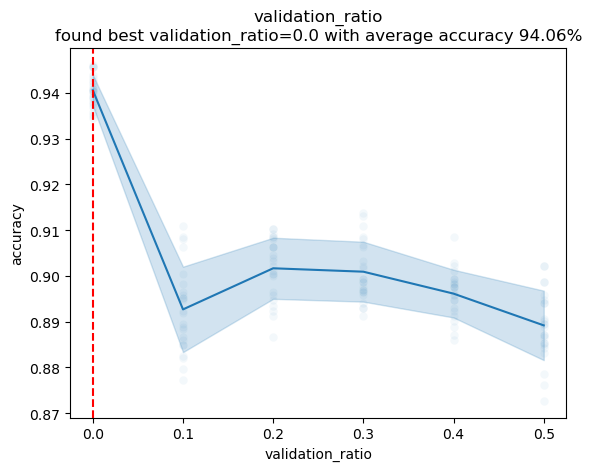

In [23]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'validation_ratio', np.linspace(0, 0.5, 6), {'max_depth': 10}, reps=24, pool=pool)

### Max Features

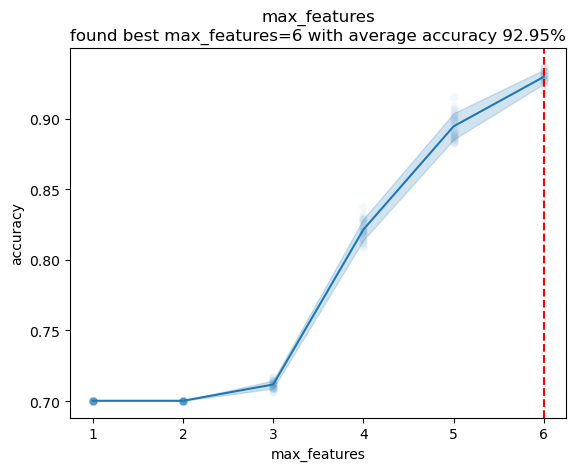

In [42]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'max_features', range(1,7),
                           {'n_estimators': 80, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

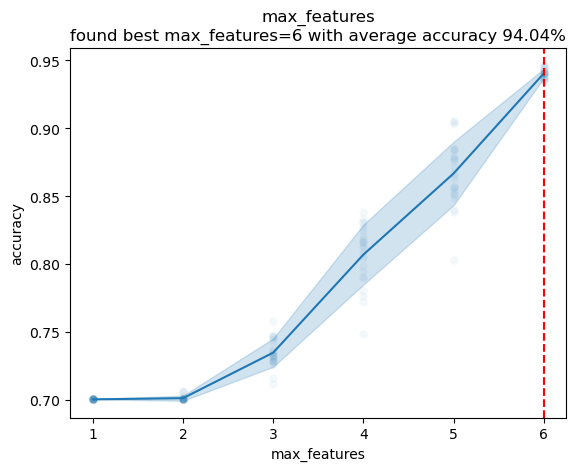

CPU times: user 359 ms, sys: 209 ms, total: 568 ms
Wall time: 2min 4s


In [44]:
%%time
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'max_features', range(1,7),
                           {'n_estimators': 10, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': 0}},
                           reps=24, pool=pool)

### Number of estimators

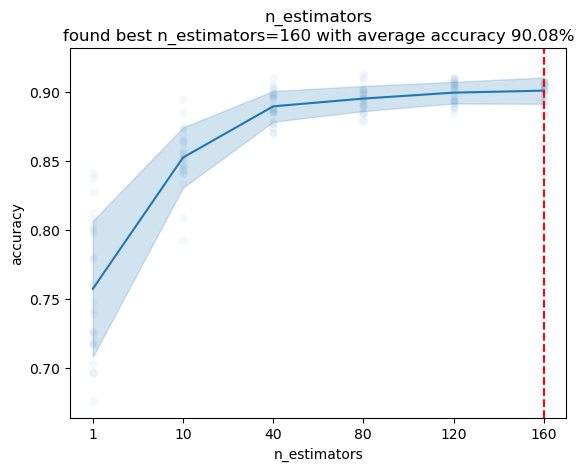

In [41]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160],
                           {'max_features': 5, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

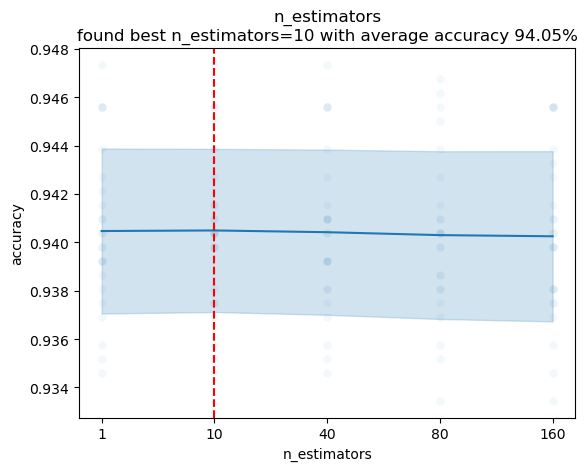

CPU times: user 407 ms, sys: 253 ms, total: 659 ms
Wall time: 27min 4s


In [29]:
%%time
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': 0 }},
                           reps=24, pool=pool)

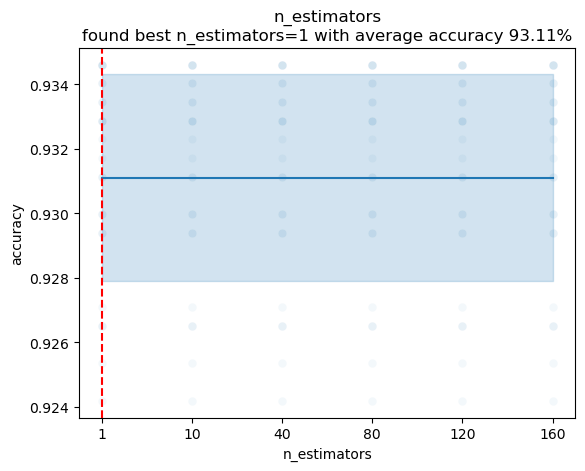

In [33]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'evaluate_model', 'max_depth': 6}},
                           reps=24, pool=pool)

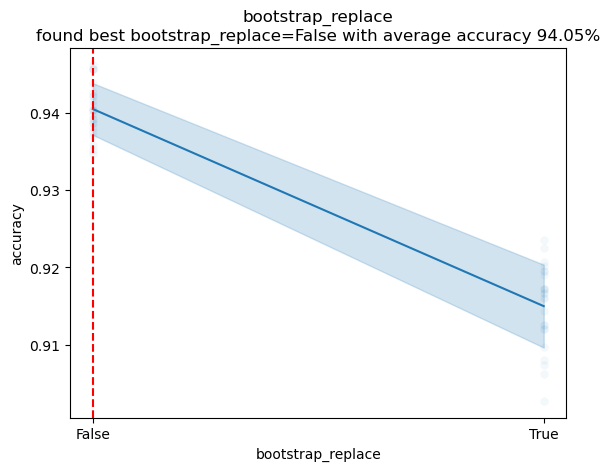

In [34]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_replace', [False, True],
                           {'max_features': 6, 'n_estimators': 1, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': 0 }},
                            reps=24, pool=pool)

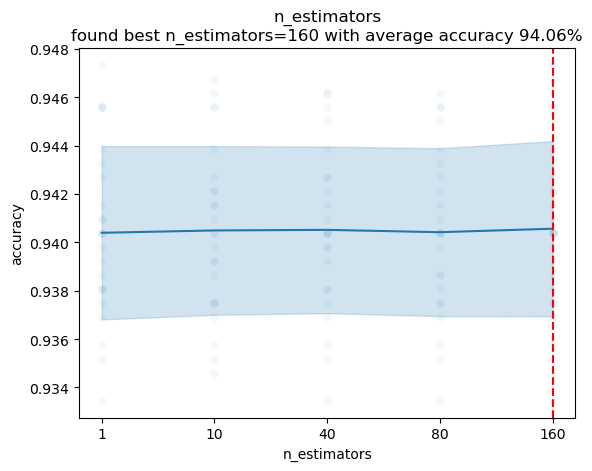

CPU times: user 339 ms, sys: 184 ms, total: 523 ms
Wall time: 26min 52s


In [35]:
%%time
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 160],
                           {'max_features': 6, 'bootstrap_replace': False, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': 0}},
                           reps=24, pool=pool)

### Bootstrap Fraction

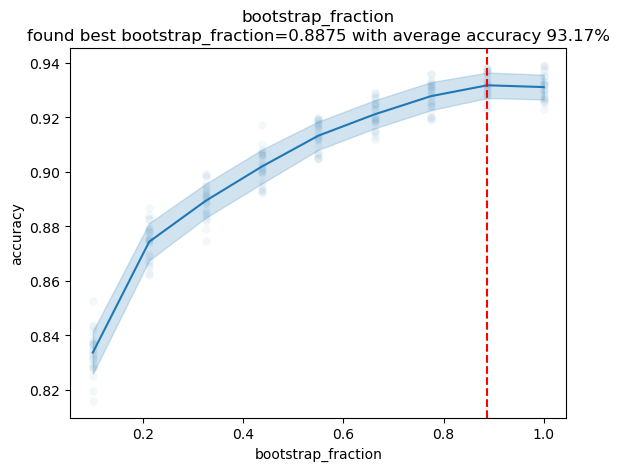

In [36]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9),
                           {'max_features': 6, 'n_estimators': 10, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

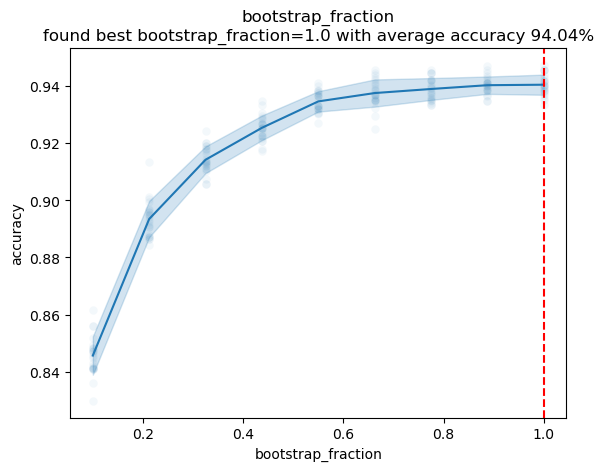

In [37]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9),
                           {'max_features': 6, 'n_estimators': 10, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': 0}},
                           reps=24, pool=pool),

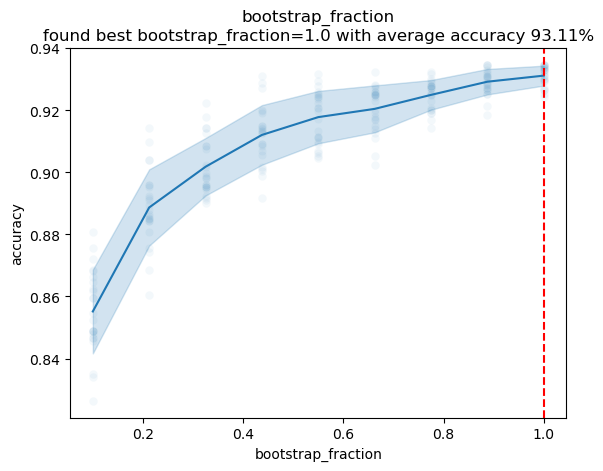

In [38]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'bootstrap_fraction', np.linspace(0.1, 1, 9),
                           {'max_features': 6, 'n_estimators': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'sklearn', 'max_depth': 6}},
                           reps=24, pool=pool)

### Sampling Temperature

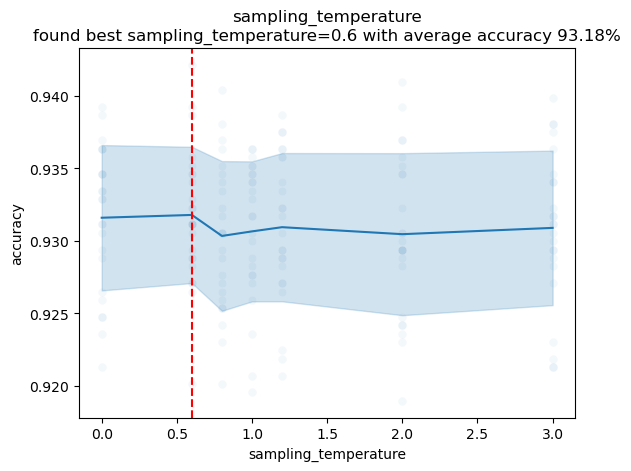

In [49]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 0.8875, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

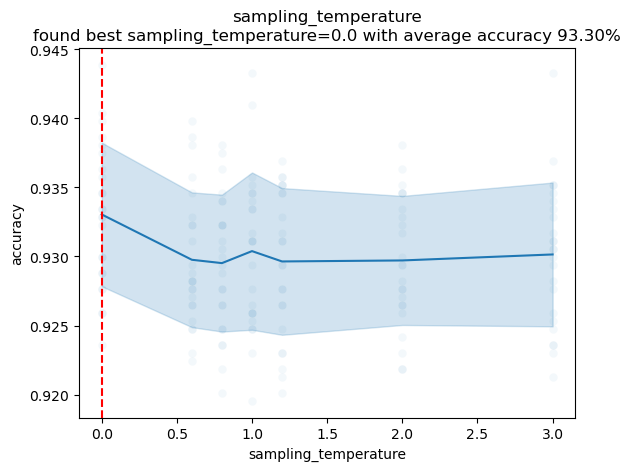

In [51]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 80, 'max_features': 6, 'bootstrap_fraction': 0.8875, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}},
                           reps=24, pool=pool)

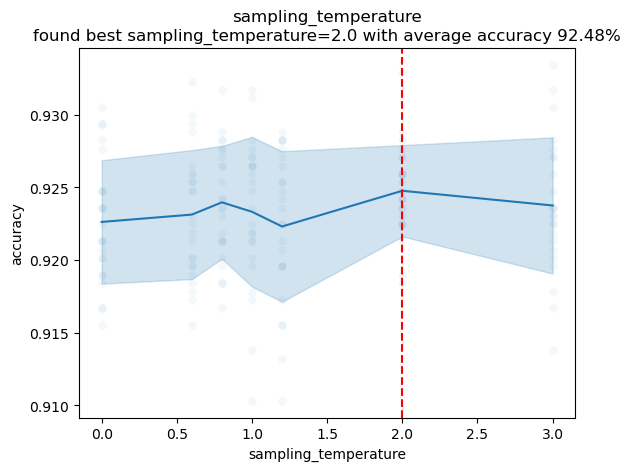

In [52]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'sampling_temperature', [0., 0.6, 0.8, 1, 1.2, 2., 3.],
                           {'n_estimators': 10, 'max_features': 6, 'bootstrap_fraction': 1, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10}},
                           reps=24, pool=pool)

## Evaluate model on best hyperparameters

0.9293981481481481

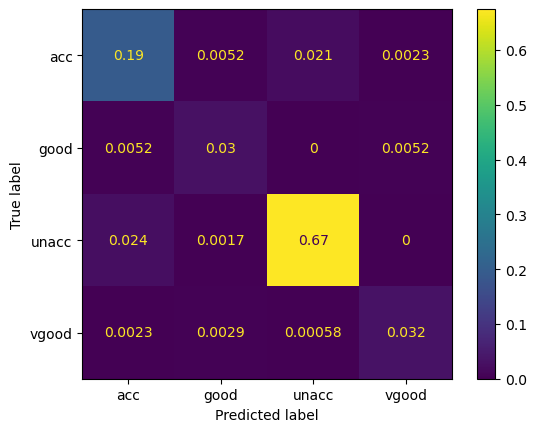

In [55]:
evaluate_model(X, Y, rf_constructor, {'n_estimators': 80, 'max_features': 6, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}, 'bootstrap_fraction': 0.8875,
                                     'sampling_temperature': 0.6, 'random_seed': 42})

In [ ]:
evaluate_model(X, Y, rf_constructor, {'n_estimators': 10, 'max_features': 6, 'tree_kwargs': {'kind': 'id3', 'max_depth': 5}, 'bootstrap_fraction': 0.8875,
                                     'sampling_temperature': 0.6, 'random_seed': 42})

## Gender DataSet


In [31]:
df, columns = load_dataset('gender')
X, Y = df.drop(columns='target'), df['target']

columns

{'long_hair': [0, 1],
 'nose_wide': [0, 1],
 'nose_long': [0, 1],
 'lips_thin': [0, 1],
 'distance_nose_to_lip_long': [0, 1]}

### Max Depth

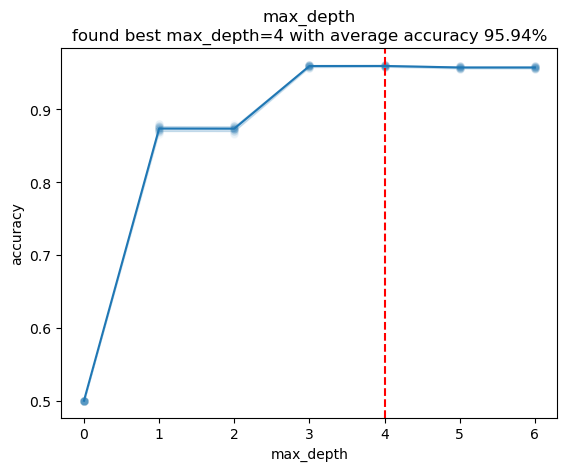

In [29]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, id3_constructor, 'max_depth', range(7), {}, reps=24, pool=pool)

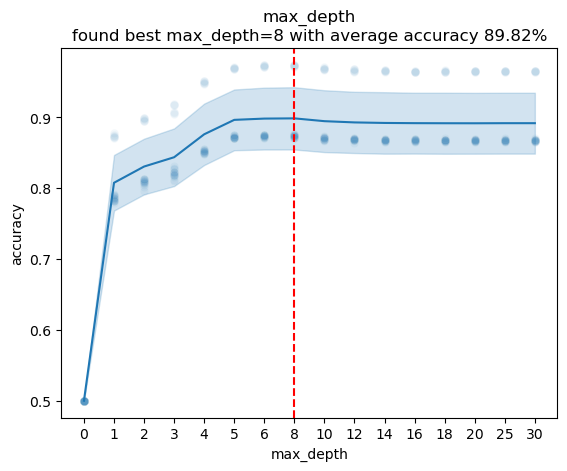

In [30]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'max_depth', [0 , 1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30], {'validation_ratio': 0}, reps=24, pool=pool)

### Validation ratio

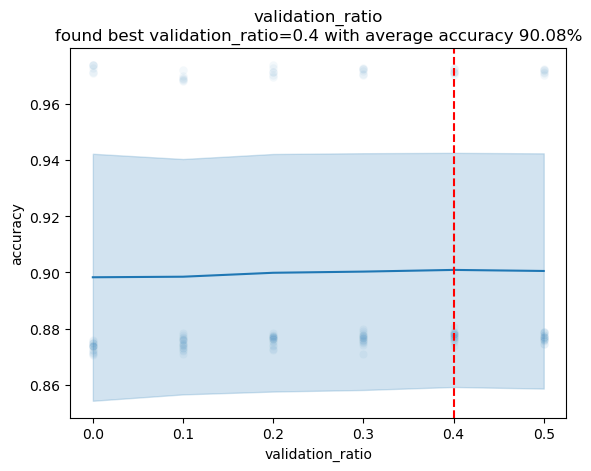

In [33]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, c45_constructor, 'validation_ratio', np.linspace(0, 0.5, 6), {'max_depth': 8}, reps=24, pool=pool)

### Number of estimators

In [ ]:
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 120, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'id3', 'max_depth': 4}},
                           reps=24, pool=pool)

In [ ]:
%%time
with Pool(24) as pool:
    plot_factor_dependency(X, Y, rf_constructor, 'n_estimators', [1, 10, 40, 80, 160],
                           {'max_features': 6, 'bootstrap_fraction': 1, 'sampling_temperature': 0, 'tree_kwargs': {'kind': 'c45', 'max_depth': 10, 'validation_ratio': 0.4 }},
                           reps=24, pool=pool)